In [1]:
import gzip
from glob import glob
import os
import shutil
import urllib.request as request
from contextlib import closing
from datetime import datetime
from dateutil import tz

import matplotlib.pyplot as plt
import xarray as xr
from xarray.backends import NetCDF4DataStore
import numpy as np
from scipy.ndimage import gaussian_filter
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import metpy.calc as mpcalc
import cf2cdm

In [36]:
%%capture
VALID_TIME = '2020-05-04T1800'

rap = 'https://nomads.ncep.noaa.gov/dods/rap/rap20200505/rap_09z'

ds_rap = xr.open_dataset(rap, decode_times=True)
ds_rap = ds_rap.metpy.parse_cf()

In [4]:
# Download files

mrms = {
    'reflectivity_lowest_altitude': 'https://mrms.ncep.noaa.gov/data/2D/ReflectivityAtLowestAltitude/MRMS_ReflectivityAtLowestAltitude.latest.grib2.gz',
}

def download_mrms(file_url):
    file = file_url.split('/')[-1]
    grib2 = '.'.join(file.split('.')[0:-1])
    
    with closing(request.urlopen(file_url)) as r:
        with open(file, 'wb') as f:
            shutil.copyfileobj(r, f)
    
    with gzip.open(file, 'rb') as f_in:
        with open(grib2, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

for grib2 in mrms.values():
    download_mrms(grib2)

In [9]:
# Read in files and acquire data needed for plotting

BOTTOM_LAT = 34
TOP_LAT = 42
LEFT_LON = 360-100
RIGHT_LON = 360-80

LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)
LON_SLICE = slice(LEFT_LON, RIGHT_LON)

ds = xr.load_dataset(glob('MRMS_ReflectivityAtLowestAltitude*.grib2')[0], engine='cfgrib',
                     backend_kwargs={'indexpath':''})
ds = ds.metpy.parse_cf()
ds = cf2cdm.translate_coords(ds, cf2cdm.CDS)

lats = ds.lat.sel(lat=LAT_SLICE)
lons = ds.lon.sel(lon=LON_SLICE)

mrms_values = ds.paramId_0.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE).squeeze().metpy.unit_array

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [31]:
BOTTOM_LAT_RAP = 30
TOP_LAT_RAP = 42
LEFT_LON_RAP = -100
RIGHT_LON_RAP = -75
LAT_SLICE_RAP = slice(BOTTOM_LAT_RAP, TOP_LAT_RAP)
LON_SLICE_RAP = slice(LEFT_LON_RAP, RIGHT_LON_RAP)
lats_rap = ds_rap.lat.sel(lat=LAT_SLICE_RAP).values
lons_rap = ds_rap.lon.sel(lon=LON_SLICE_RAP).values
lons_rap = 360 + lons_rap
thetae = ds_rap.epotsfc.metpy.sel(lat=LAT_SLICE_RAP, lon=LON_SLICE_RAP, 
                                  time='2020-05-04T18:00:00').squeeze().metpy.unit_array

[30.17519282 30.35990191 30.544611   30.72932009 30.91402918 31.09873827
 31.28344736 31.46815645 31.65286555 31.83757464 32.02228373 32.20699282
 32.39170191 32.576411   32.76112009 32.94582918 33.13053827 33.31524736
 33.49995645 33.68466555 33.86937464 34.05408373 34.23879282 34.42350191
 34.608211   34.79292009 34.97762918 35.16233827 35.34704736 35.53175645
 35.71646555 35.90117464 36.08588373 36.27059282 36.45530191 36.640011
 36.82472009 37.00942918 37.19413827 37.37884736 37.56355645 37.74826555
 37.93297464 38.11768373 38.30239282 38.48710191 38.671811   38.85652009
 39.04122918 39.22593827 39.41064736 39.59535645 39.78006555 39.96477464
 40.14948373 40.33419282 40.51890191 40.703611   40.88832009 41.07302918
 41.25773827 41.44244736 41.62715645 41.81186555 41.99657464]
[260.16793964 260.36036532 260.55279101 260.7452167  260.93764238
 261.13006807 261.32249375 261.51491944 261.70734512 261.89977081
 262.0921965  262.28462218 262.47704787 262.66947355 262.86189924
 263.0543249

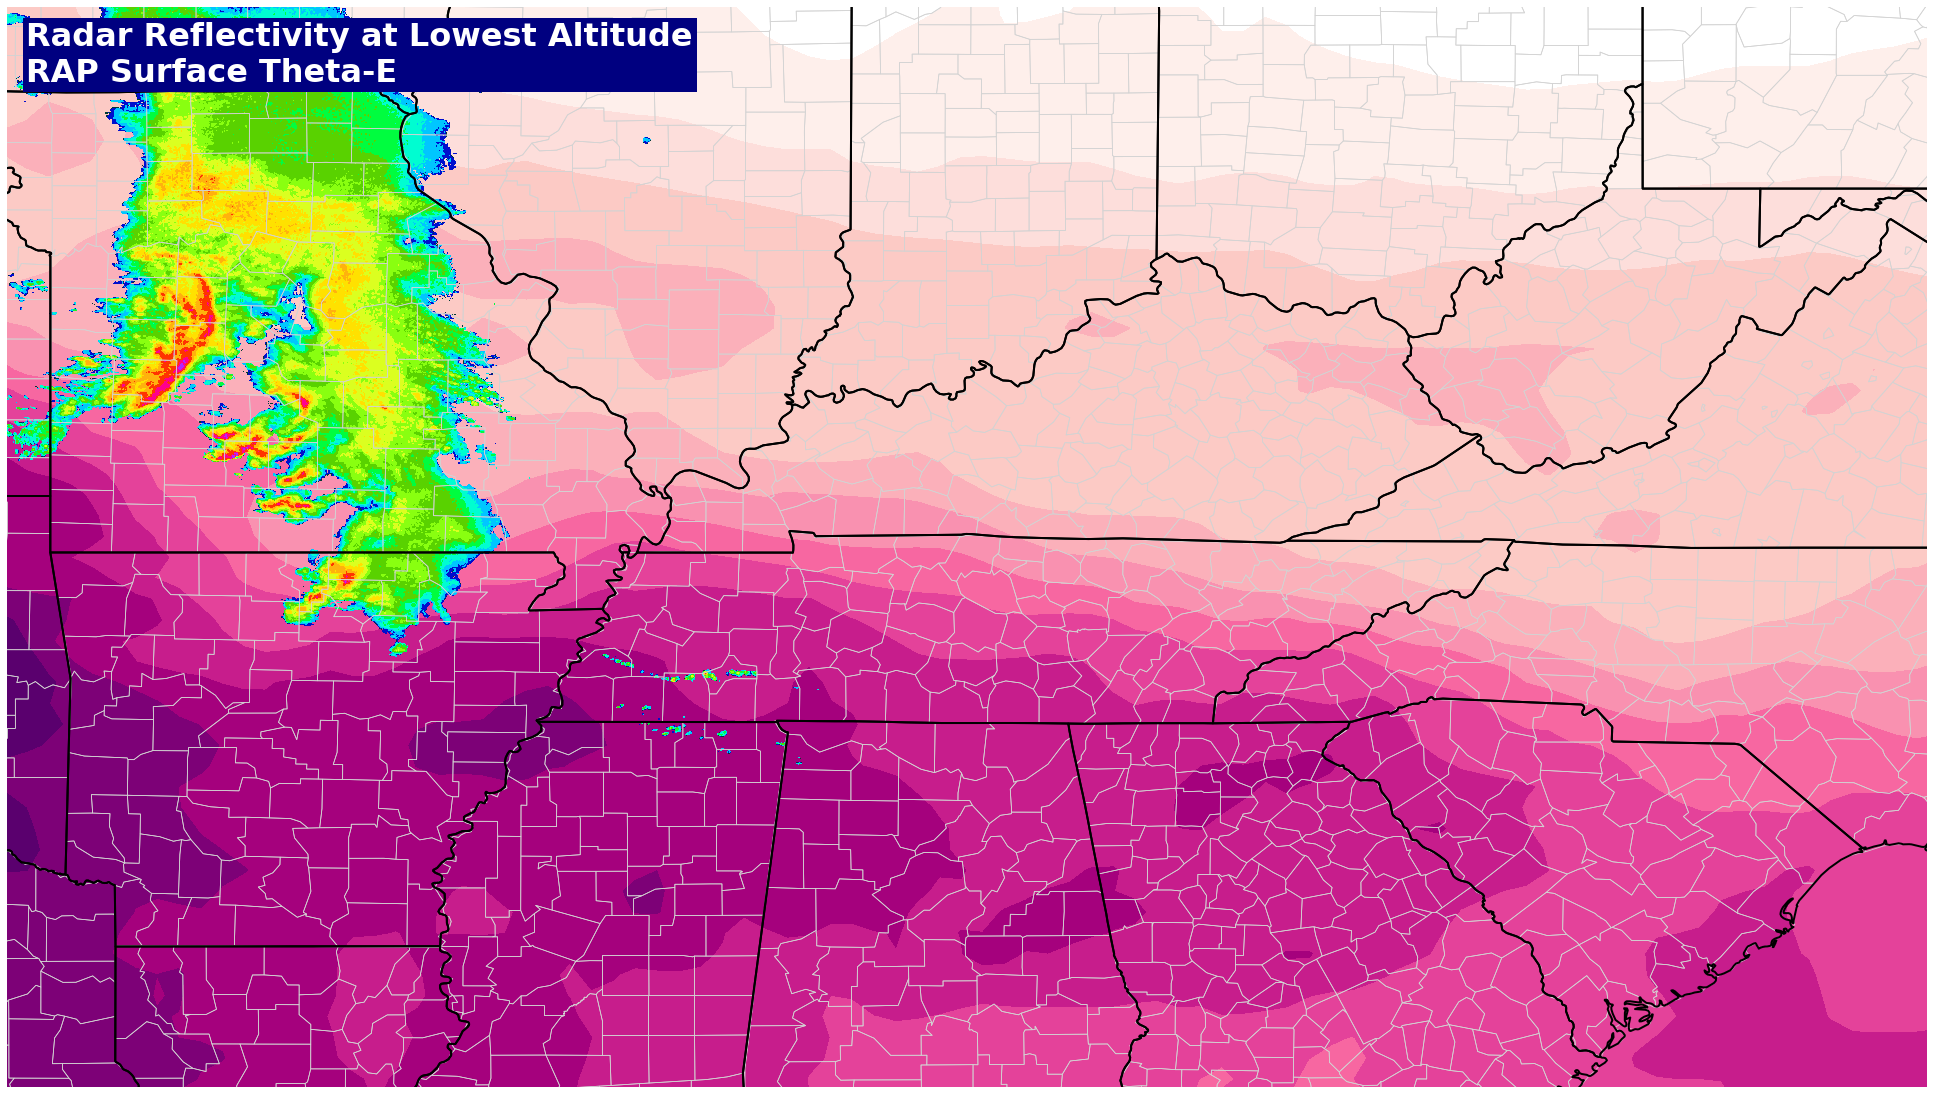

In [35]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
ax.outline_patch.set_visible(False)
#ax.set_extent([-82, -79, 31, 36])
ax.set_extent([-87, -80, 23.5, 32])
ax.set_extent([-95, -78, 33.1, 40.0])

thetae_values = np.arange(300, 360, 5)
thetae_fill = ax.contourf(lons_rap, lats_rap, thetae, thetae_values,
                          cmap=plt.cm.RdPu, transform=ccrs.PlateCarree())

range_reflectivity = [num for num in range(0, 80, 5)]
contour = ax.contourf(lons, lats, mrms_values, range_reflectivity, 
                     cmap=plt.cm.gist_ncar, transform=ccrs.PlateCarree())


# cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
# cbar.ax.tick_params(labelsize='24')

# Make the axis title
ax.set_title('Radar Reflectivity at Lowest Altitude\nRAP Surface Theta-E', loc='left', 
             ha='left', va='center', fontsize=32, color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))


# Plot cities
# cities = {
#     'Pensacola': [30.4213, -87.2169],
#     'Tallahassee': [30.4383, -84.2807],
#     'Gainesville': [29.6516, -82.3248],
#     'Tampa': [27.9506, -82.4572],
#     'Orlando': [28.5383, -81.3792],
#     'Ft Myers': [26.6406, -81.8723],
#     'Miami': [25.7617, -80.1918],
#     'Key West': [24.5551, -81.7800]
# }

# def plot_cities(lat, lon, city_name):
#     ax.text(lon, lat, city_name, fontsize=28, zorder=10, fontweight='bold', fontname='Arial', backgroundcolor='black',
#             color='white', ha='center', transform=ccrs.PlateCarree())

# for city in cities.keys():
#     plot_cities(cities[city][0], cities[city][1], city)

# Save and show figure
plt.savefig('mrms_sc_RALA_thetae.png', dpi=72)
plt.show()